# Explore flight delay data

This notebook replicates the month-delay relationship from NB1 while using general functions.

All categorical variables to predict delay time:
1. Month
2. Day of week 
3. Airline
4. Flight number 
5. Tail number
6. Origin airport 
7. Destination airport
8. scheduled departure hour
9. scheduled arrival hour

Continuous variables to predict delay time:
1. scheduled duration
2. distance


Delay time could be
* Calculate extra in-plane delay (ARRIVAL_DELAY - DEPARTURE_DELAY)
    * From this we could see which airlines speed up the most to make up for lost time
    * Maybe should account for delay by TAXI_OUT time
* Arrival_delay could be an extension in TAXI_IN, TAI_OUT, or AIR_TIME?
    * Reference based on the average TAXI_IN and TAXI_OUT time

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style('white')

# Load data

In [2]:
def load_data(data_folder = '/gh/data/flightdelay/',
             N_flights = None):
    df_al = pd.DataFrame.from_csv(data_folder+'airlines.csv')
    df_ap = pd.DataFrame.from_csv(data_folder+'airports.csv')
    
    if N_flights is None:
        df_fl = pd.io.parsers.read_csv(data_folder+'flights.csv')
    else:
        df_fl = pd.io.parsers.read_csv(data_folder+'flights.csv', nrows = N_flights)
        
    return df_al, df_ap, df_fl

In [3]:
def restrict_df(df, restriction):
    restrict_keys = restriction.keys()
    for k in restrict_keys:
        N_vals = len(restriction[k])
        df_keep = [0]*N_vals
        for i in range(N_vals):
            df_keep[i] = df[df[k]==restriction[k][i]]
        df = pd.concat(df_keep)
    return df

In [4]:
def load_data_SAN(drop_cancelled = True):
    
    # Load all data
    _, _, df_fl = load_data()
    
    # Restrict to SAN data
    restrict = {}
    restrict['ORIGIN_AIRPORT'] = ['SAN','14679',14679]
    df_SAN = restrict_df(df_fl, restrict)

    # If needed, remove the cancelled flights
    if drop_cancelled:
        df_SAN = df_SAN[np.isfinite(df_SAN['DEPARTURE_DELAY'])]
        
    return df_SAN

In [5]:
df_SAN = load_data_SAN()

/Users/scott/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
print(len(df_SAN))
print(df_SAN.keys())

75630
Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')


In [7]:
df_SAN.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
477,2015,1,1,4,DL,978,N693DL,SAN,SLC,615,...,906.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
500,2015,1,1,4,OO,5608,N930SW,SAN,LAX,615,...,702.0,-5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
517,2015,1,1,4,WN,823,N7707C,SAN,BWI,620,...,1352.0,-23.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
518,2015,1,1,4,WN,603,N461WN,SAN,MDW,620,...,1201.0,-29.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
520,2015,1,1,4,UA,1192,N69804,SAN,DEN,620,...,936.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# General exploration function

Input:
    Analysis type
    Mean_by_group
    plot_quantiles
    Output:


In [8]:
from matplotlib import cm
def getcmaprgb(N, cmap):
    """Get the RGB values of N colors across the jet spectrum"""
    return cmap(np.linspace(0,255,N).astype(int))

In [9]:
# Functions to explore certain patterns between two variables x and y
def split_y_by_x(x, y, return_all_x = False, return_N_x = False):
    # Find the delays for each month
    all_x = np.unique(x)
    N_x = len(all_x)
    y_by_x = np.zeros(N_x, dtype=np.ndarray)
    for i in range(N_x):
        y_by_x[i] = y[x==all_x[i]]
        
    if return_all_x:
        if return_N_x:
            return y_by_x, all_x, N_x
        else:
            return y_by_x, all_x
    else:
        if return_N_x:
            return y_by_x, N_x
        else:
            return y_by_x

In [10]:
def relation_explorer(df, key_predict, key_feature,
                      analysis_fn, analysis_kwargs = {},
                      restriction = None, feature_is_categorical = True, make_plot = True):
    """
    Compute the relationship between two features in the data
    
    Parameters
    ----------
    df : pandas DataFrame
        data
    key_predict : str
        column of `df` to predict
    key_feature : str
        column of `df` to use as the predictive feature
    restriction : None or dict of type {key: list}
        if None: there are no restrictions on which data is included
        if dict: restrict `df` to only the rows in which the key of `restriction` takes on one of the values in the list
    feature_is_categorical : bool
        if True, the predictive feature is assumed to be categorical in nature
        if False, the predictive feature is assume to be ordinal in nature
        
    Returns
    -------
    out : varies
        output of the `analysis_fn`
    """
    
    # Restrict the data, if necessary
    if restriction is not None:
        df = restrict_df(df, restriction)
        
    # Determine the thing to predict
    y = df[key_predict].values
    
    # Determine the predictor
    x = df[key_feature].values
    
    if feature_is_categorical:
        # Split y by x
        y_by_x, all_x, N_x = split_y_by_x(x, y, return_all_x = True, return_N_x = True)
        
        # Set default histogram params
        out = analysis_fn(y_by_x, all_x = all_x, make_plot = make_plot, **analysis_kwargs)
        
    else:
        raise NotImplementedError('TODO')
        
    return out
    

In [11]:
def relation_histogram(y_by_x, all_x = None, bin_edges = None, make_plot = True):
    
    # Set default histogram edges
    if bin_edges is None:
        bin_edges = np.percentile(np.hstack(y_by_x),np.arange(0,110,10))
        
    N_x = len(y_by_x)
    y_by_x_hist = np.zeros(N_x, dtype=np.ndarray)
    for i in range(N_x):
        y_by_x_hist[i], _ = np.histogram(y_by_x[i], bin_edges, density=True)
        
    if make_plot:
        if all_x is None:
            all_x = np.arange(N_x)
            
        x_cmap = getcmaprgb(N_x, cm.jet)
        for i in range(N_x):
            plt.plot(bin_edges[:-1], y_by_x_hist[i], '.-', color=x_cmap[i], label=all_x[i], alpha=0.5)
        plt.legend()
        plt.xticks(bin_edges[:-1])
        
    return y_by_x_hist, bin_edges


from statsmodels.distributions.empirical_distribution import ECDF

def relation_ecdf(y_by_x, all_x = None, make_plot = True):
    
    # Make cumulative distribution function for each month
    N_x = len(y_by_x)
    y_by_x_cdfy = np.zeros(N_x, dtype=np.ndarray)
    for i in range(N_x):
        ecdf = ECDF(y_by_x[i])
        y_by_x_cdfy[i] = ecdf(y_by_x[i])
        
    if make_plot:
        if all_x is None:
            all_x = np.arange(N_x)
            
        x_cmap = getcmaprgb(N_x, cm.jet)
        for i in range(N_x):
            plt.plot(y_by_x[i],y_by_x_cdfy[i],'.', color=x_cmap[i], label=all_x[i], alpha=0.5)
        plt.legend()
        
    return y_by_x_cdfy


def relation_quantiles(y_by_x, all_x = None, all_quantiles = None, make_plot = True):
    """Plot the quantiles of y for each value of x"""
    
    if all_quantiles is None:
        all_quantiles = np.arange(10,100,10)
    N_quantiles = len(all_quantiles)
    N_x = len(y_by_x)
    
    y_by_x_quantile = np.zeros((N_x,N_quantiles))
    for i in range(N_x):
        y_by_x_quantile[i] = np.percentile(y_by_x[i],all_quantiles)
    
    
    if make_plot:
        if all_x is None:
            all_x = np.arange(N_x)
            
        quantile_cmap = getcmaprgb(N_quantiles, cm.jet)
        for i in range(N_quantiles):
            plt.plot(all_x,y_by_x_quantile[:,i],'.-',color=quantile_cmap[i], label=all_quantiles[i], alpha=0.5)
        plt.xticks(all_x)
        plt.legend()
        
    return y_by_x_quantile, all_quantiles


def relation_exceed(y_by_x, all_x = None, all_min = None, make_plot = True):
    """Determine the fraction of observations for each x that y exceeds"""
    
    if all_min is None:
        all_min = np.percentile(np.hstack(y_by_x),np.arange(10,100,10))
    N_min = len(all_min)
    N_x = len(y_by_x)
    
    
    y_by_x_min = np.zeros((N_x,N_min))
    for i in range(N_x):
        for j in range(N_min):
            y_by_x_min[i,j] = np.mean(y_by_x[i]>all_min[j])
    
    
    if make_plot:
        if all_x is None:
            all_x = np.arange(N_x)
            
        min_cmap = getcmaprgb(N_min, cm.jet)
        for i in range(N_min):
            plt.plot(all_x,y_by_x_min[:,i],'.-',color=min_cmap[i], label=all_min[i], alpha=0.5)
        plt.xticks(all_x)
        plt.legend()
        
    return y_by_x_min, all_min


def relation_mean(y_by_x, all_x = None, make_plot = True):
    """Calculate the mean of y for each value of x"""
    
    
    N_x = len(y_by_x)
    y_by_x_mean = np.zeros(N_x)
    for i in range(N_x):
        y_by_x_mean[i] = np.mean(y_by_x[i])
    
    if make_plot:
        if all_x is None:
            all_x = np.arange(N_x)
        plt.plot(all_x,y_by_x_mean,'k.-')
        plt.xticks(all_x)
        
    return y_by_x_mean

# Replicate month-delay explorations

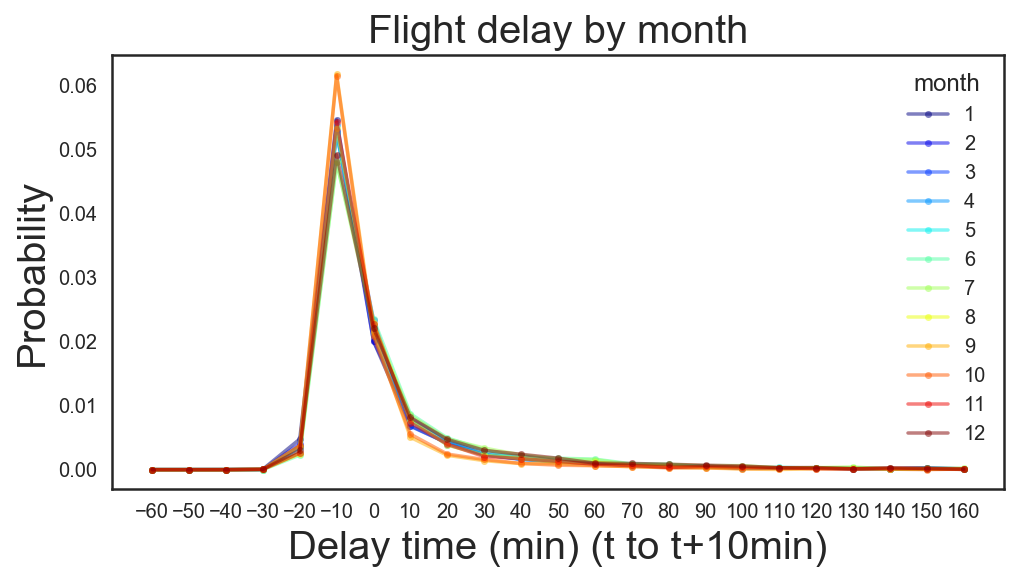

In [12]:
key_predict = 'DEPARTURE_DELAY'
key_feature = 'MONTH'
analysis_fn = relation_histogram
analysis_kwargs = {'bin_edges':np.arange(-60,180,10)}

plt.figure(figsize=(8,4))
y_by_x_hist, bin_edges = relation_explorer(df_SAN, key_predict, key_feature,
                      analysis_fn = analysis_fn, analysis_kwargs = analysis_kwargs)
plt.xlabel('Delay time (min) (t to t+10min)',size=20)
plt.ylabel('Probability', size=20)
plt.title('Flight delay by month',size=20)
plt.legend(title='month')

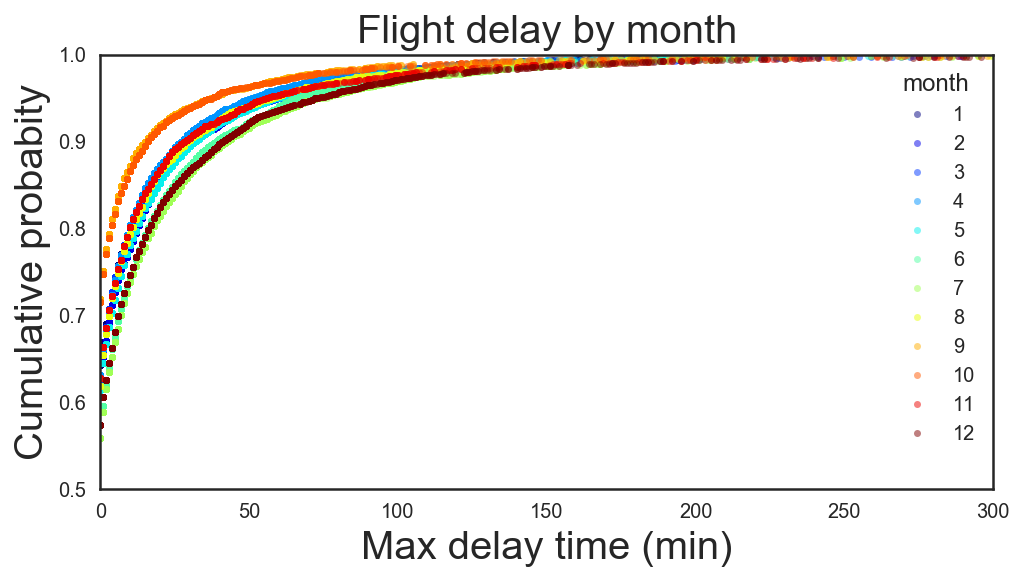

In [13]:
analysis_fn = relation_ecdf
analysis_kwargs = {}

plt.figure(figsize=(8,4))
y_by_x_cdf = relation_explorer(df_SAN, key_predict, key_feature,
                      analysis_fn = analysis_fn, analysis_kwargs = analysis_kwargs)
plt.xlim((0,300))
plt.ylim((.5,1))
plt.xlabel('Max delay time (min)',size=20)
plt.ylabel('Cumulative probabity', size=20)
plt.legend(fontsize=10,title='month')
plt.title('Flight delay by month',size=20)

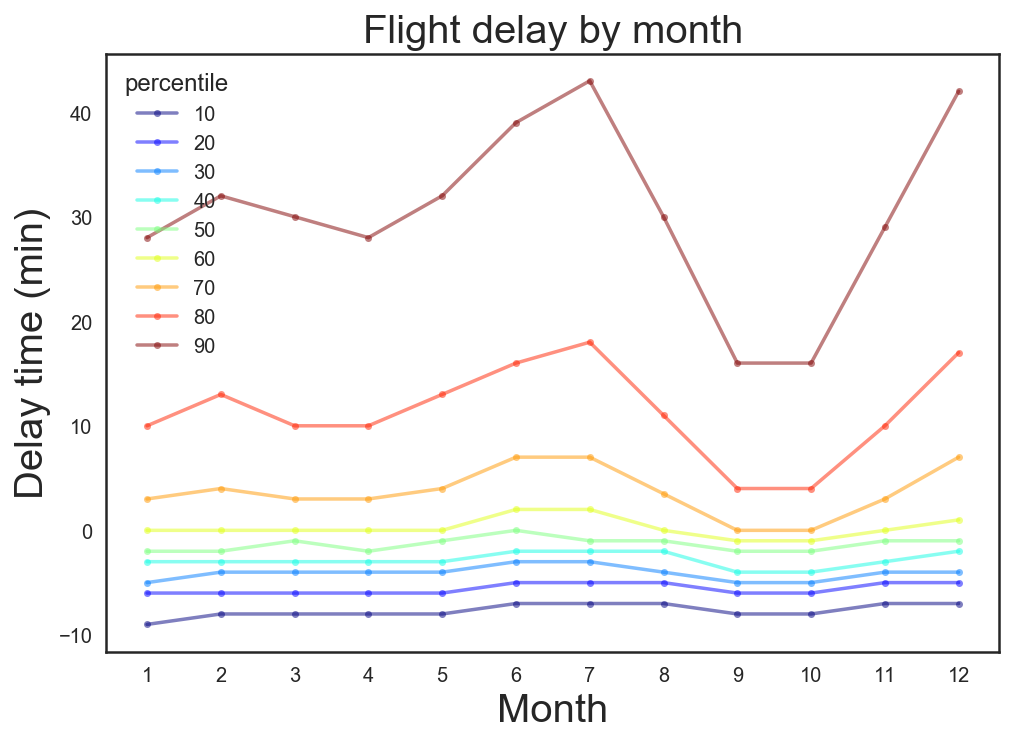

In [14]:
analysis_fn = relation_quantiles
analysis_kwargs = {'all_quantiles': np.arange(10,100,10)}
y_by_x_quantile, all_quantiles = relation_explorer(df_SAN, key_predict, key_feature,
                      analysis_fn = analysis_fn, analysis_kwargs = analysis_kwargs)
plt.xlabel('Month',size=20)
plt.ylabel('Delay time (min)', size=20)
plt.legend(fontsize=10, title='percentile')
plt.title('Flight delay by month',size=20)

(0.5, 14)

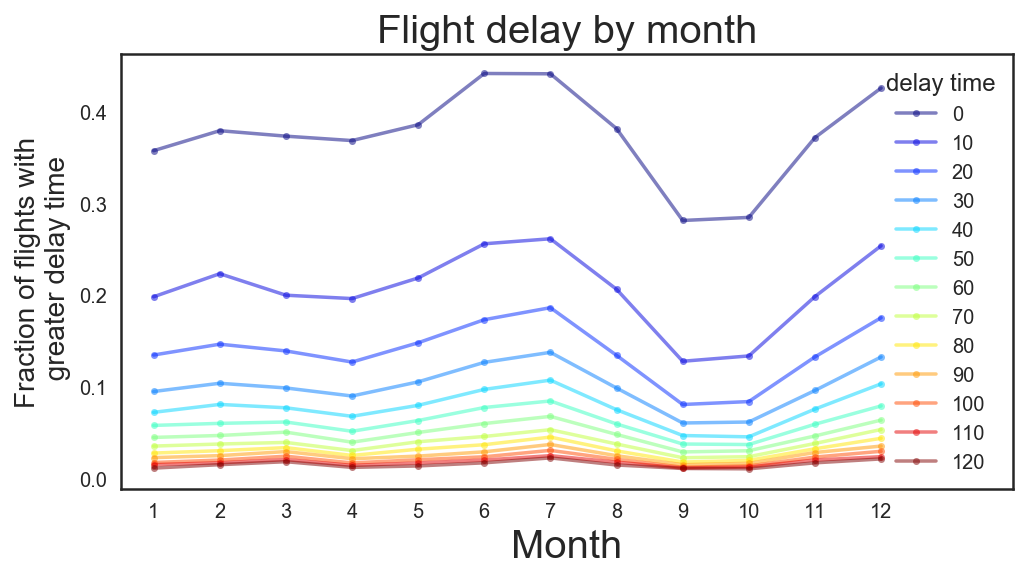

In [15]:
analysis_fn = relation_exceed
analysis_kwargs = {'all_min': np.arange(0,130,10)}
plt.figure(figsize=(8,4))
y_by_x_min , all_min = relation_explorer(df_SAN, key_predict, key_feature,
                      analysis_fn = analysis_fn, analysis_kwargs = analysis_kwargs)
plt.xlabel('Month',size=20)
plt.ylabel('Fraction of flights with\n greater delay time', size=14)
plt.legend(fontsize=10, title='delay time')
plt.title('Flight delay by month',size=20)
plt.xlim((.5,14))

(0.5, 14)

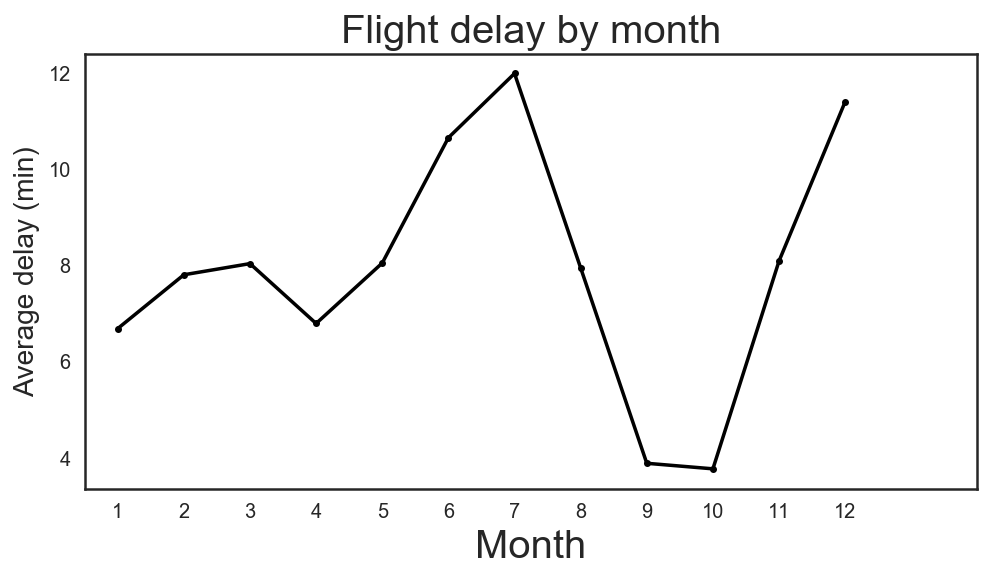

In [16]:
analysis_fn = relation_mean
analysis_kwargs = {}
plt.figure(figsize=(8,4))
y_by_x_mean = relation_explorer(df_SAN, key_predict, key_feature,
                      analysis_fn = analysis_fn, analysis_kwargs = analysis_kwargs)
plt.xlabel('Month',size=20)
plt.ylabel('Average delay (min)', size=14)
plt.title('Flight delay by month',size=20)
plt.xlim((.5,14))